In [12]:
import math
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Descriptors import ExactMolWt, HeavyAtomMolWt
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from data import PolarisDataset

In [13]:
tgts = ['MLM', 'HLM', 'MDR1-MDCKII', 'LogD', 'KSOL']
tgt = "MLM" #['MLM', 'HLM', 'MDR1-MDCKII', 'LogD', 'KSOL']

In [14]:
train_datasets = {}
test_datasets = {}
for tgt in tgts:
    train_datasets[tgt] =  PolarisDataset(root="./dataset", task=tgt, train=True, force_reload=True)
    test_datasets[tgt] = PolarisDataset(root="./dataset", task=tgt, train=False, force_reload=True)

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [18]:
for tgt in tgts:
    print("Target: ", tgt)
    train_dataset = train_datasets[tgt]
    print("Train size: ",len(train_dataset))
    y_values = [data.y for data in train_dataset]

    print("min - avg - max")
    min = np.min(y_values)
    avg = np.average(y_values)
    max = np.max(y_values)
    print(str(min) + " " +"{:.2f}".format(avg)+ " " + str(max))
    print("------")

    test_dataset = test_datasets[tgt]
    print("Test size: ", len(test_dataset))

    y_values = [data.y for data in test_dataset]
    print("min - avg - max")
    min = np.min(y_values)
    avg = np.average(y_values)
    max = np.max(y_values)
    print(str(min) + " " +"{:.2f}".format(avg)+ " " + str(max))
    print("--------------------")

Target:  MLM
Train size:  303
min - avg - max
0.0 176.90 2380.0
------
Test size:  106
min - avg - max
0.47712126 1.93 3.0374265
--------------------
Target:  HLM
Train size:  301
min - avg - max
0.0 124.25 1620.0
------
Test size:  112
min - avg - max
0.845098 2.46 2.60206
--------------------
Target:  MDR1-MDCKII
Train size:  425
min - avg - max
0.0 4.65 35.7
------
Test size:  122
min - avg - max
-0.26280737 2.16 3.2966652
--------------------
Target:  LogD
Train size:  352
min - avg - max
-0.7 2.21 4.5
------
Test size:  126
min - avg - max
-1.2620127 0.80 1.55145
--------------------
Target:  KSOL
Train size:  365
min - avg - max
2.0 212.76 398.0
------
Test size:  126
min - avg - max
0.3 1.96 4.3
--------------------


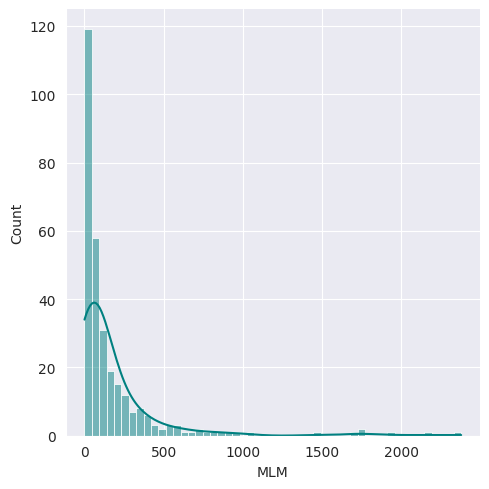

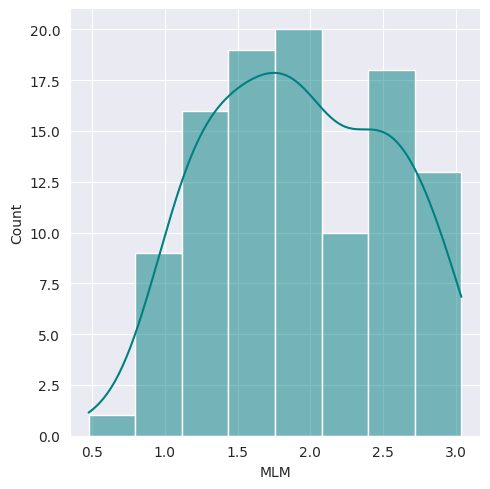

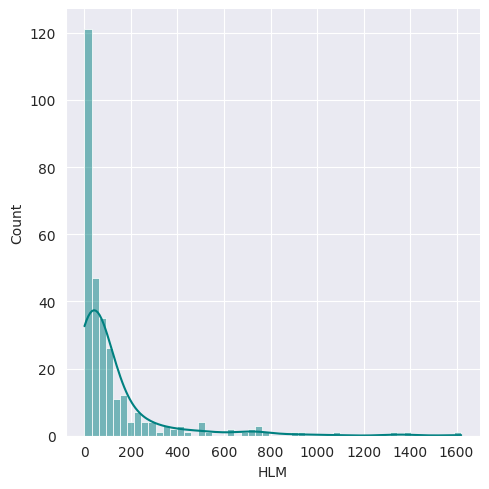

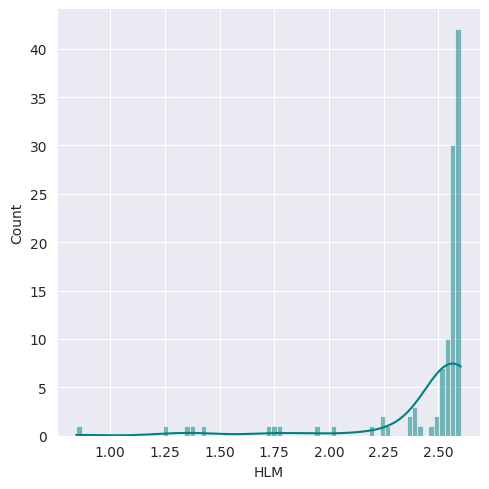

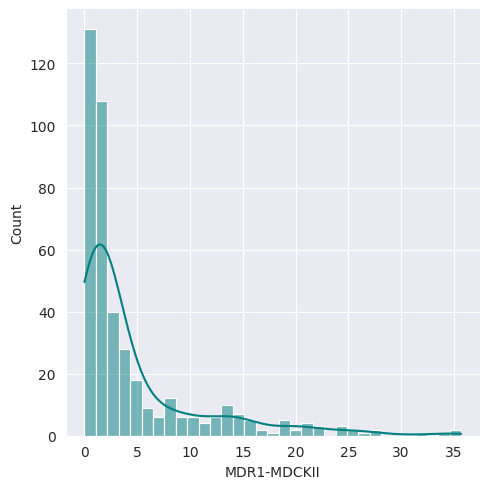

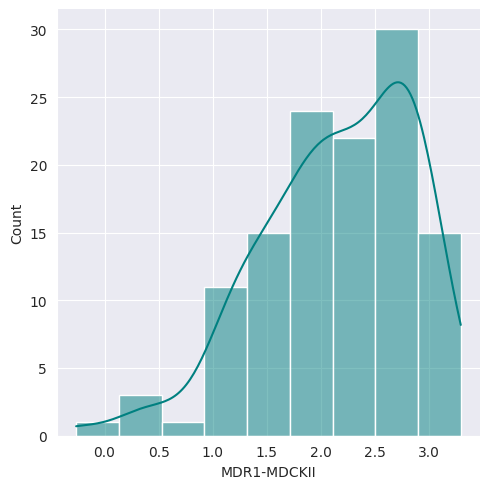

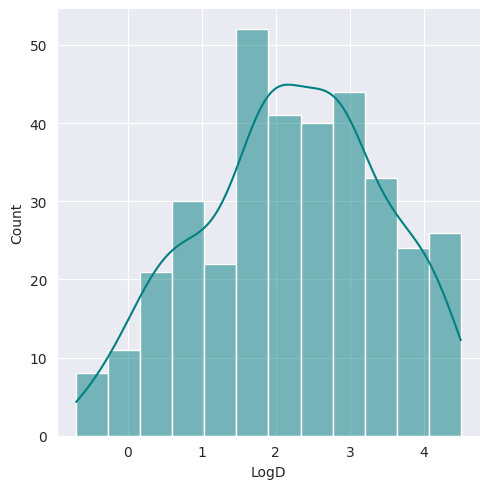

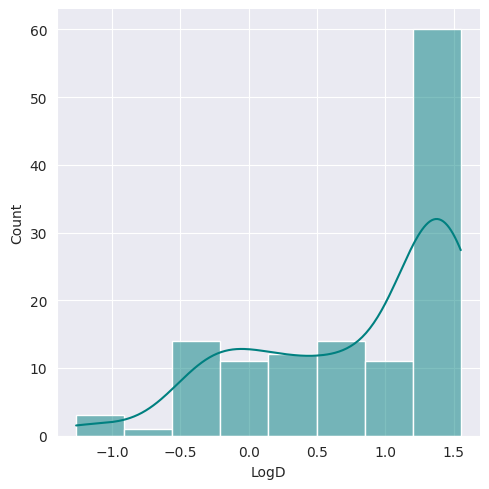

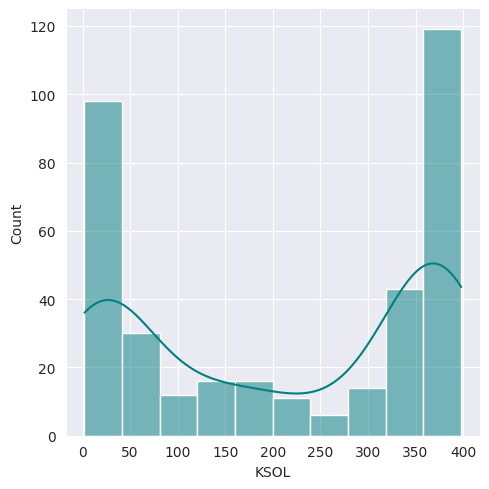

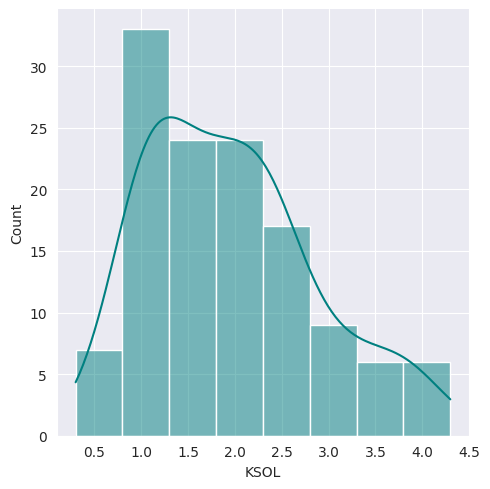

In [19]:
for tgt in tgts:
    train_dataset = train_datasets[tgt]
    y_values = [data.y.item() for data in train_dataset]
    sns.displot(data=pd.DataFrame({tgt: y_values}),
            x=tgt, kde=True, color='teal')

    test_dataset = test_datasets[tgt]
    y_values = [data.y.item() for data in test_dataset]
    sns.displot(data=pd.DataFrame({tgt: y_values}),
            x=tgt, kde=True, color='teal')
plt.show()

In [ ]:
# the same, but better + min max avg
for tgt in train.target_cols:
    y = train.y[tgt]
    mask = ~np.isnan(y)
    print(tgt)
    print("Number of samples "+ str(sum(mask)))

    print("min - avg - max")
    min = np.min(y[mask])
    avg = np.average(y[mask])
    max = np.max(y[mask])
    print(str(min) + " " +"{:.2f}".format(avg)+ " " + str(max))


    print("--------------------")

In [ ]:
# draw distribution for each target
for tgt in train.target_cols:
    y = train.y[tgt]
    mask = ~np.isnan(y)
    data = train.y[tgt][mask]
    sns.displot(data=pd.DataFrame({tgt: data}),
            x=tgt, kde=True, color='teal')
plt.show()

In [ ]:
# get mols from smiles
smiles_train = [smiles[0] for smiles in train]
mols_train = [Chem.MolFromSmiles(smiles_train[i]) for i in range(len(smiles_train))]


smiles_test = test
mols_test = [Chem.MolFromSmiles(smiles_test[i]) for i in range(len(smiles_test))]

In [ ]:
# draw some molecules for each target for each category (min, avg, max)
# Draw.MolsToGridImage(mols_test, molsPerRow=3, subImgSize=(300, 300))

#for tgt in train.target_cols: # why doesn't it print those, if I loop it :(
tgt = "MLM" #['MLM', 'HLM', 'MDR1-MDCKII', 'LogD', 'KSOL']
y = train.y[tgt]
mask = ~np.isnan(y)
min = np.min(y[mask])

min_indices = np.where(y == min)[0]
mols = [mols_train[i] for i in min_indices]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300))

In [ ]:
max = np.max(y[mask])

max_indices = np.where(y == max)[0]
mols = [mols_train[i] for i in max_indices]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300))

In [ ]:
avg = np.average(y[mask])

avg_indices = [0] # todo: find avg indices
mols = [mols_train[i] for i in avg_indices]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300))

In [ ]:
# distribution of molecular weight
# train

weights = [ExactMolWt(mol) for mol in mols_train]
sns.displot(data=pd.DataFrame({"Weights Train": weights}),
            x="Weights Train", kde=True, color='teal')
plt.show()

#test

weights = [ExactMolWt(mol) for mol in mols_test]
sns.displot(data=pd.DataFrame({"Weights Test": weights}),
            x="Weights Test", kde=True, color='teal')
plt.show()


In [ ]:
# distribution of molecular weight
# train

weights = [HeavyAtomMolWt(mol) for mol in mols_train]
sns.displot(data=pd.DataFrame({"Weights Train": weights}),
            x="Weights Train", kde=True, color='teal')
plt.show()

#test

weights = [HeavyAtomMolWt(mol) for mol in mols_test]
sns.displot(data=pd.DataFrame({"Weights Test": weights}),
            x="Weights Test", kde=True, color='teal')
plt.show()


In [ ]:
# distribution of number of atoms
# train

weights = [mol.GetNumAtoms() for mol in mols_train]
sns.displot(data=pd.DataFrame({"Num Atoms Train": weights}),
            x="Num Atoms Train", kde=True, color='teal')
plt.show()

#test

weights = [mol.GetNumAtoms() for mol in mols_test]
sns.displot(data=pd.DataFrame({"Num Atoms Test": weights}),
            x="Num Atoms Test", kde=True, color='teal')
plt.show()


In [ ]:
# distribution of similarity in train/test
# train
fps_train = [FingerprintMols.FingerprintMol(x) for x in mols_train]
sim = []

for i in range(len(fps_train)-1):
    for j in range(i, len(fps_train)):
        sim.append(DataStructs.TanimotoSimilarity(fps_train[i], fps_train[j]))

sns.displot(data=pd.DataFrame({"Similarity in Train": sim}),
            x="Similarity in Train", kde=True, color='teal')
plt.show()

#test
fps_test = [FingerprintMols.FingerprintMol(x) for x in mols_test]
sim = []

for i in range(len(fps_test)-1):
    for j in range(i, len(fps_test)):
        sim.append(DataStructs.TanimotoSimilarity(fps_test[i], fps_test[j]))


sns.displot(data=pd.DataFrame({"Similarity in Test": sim}),
            x="Similarity in Test", kde=True, color='teal')
plt.show()


In [ ]:
# distribution of similarity between train and test
sim = []
for i in range(len(fps_train)):
    for j in range(len(fps_test)):
        sim.append(DataStructs.TanimotoSimilarity(fps_train[i], fps_test[j]))

sns.displot(data=pd.DataFrame({"Similarity between Train and Test": sim}),
            x="Similarity between Train and Test", kde=True, color='teal')



In [ ]:
# distribution of max similarity between train and test
sim = []
for i in range(len(fps_test)):
    max = 0
    for j in range(len(fps_train)):
        simi = DataStructs.TanimotoSimilarity(fps_test[i], fps_train[j])
        if simi > max:
            max = simi
    sim.append(max)

sns.displot(data=pd.DataFrame({"Max Similarity between Test and Train": sim}),
            x="Max Similarity between Test and Train", kde=True, color='teal')


In [ ]:
# scatter tgt vs mol weight
for tgt in train.target_cols:
    weights = [HeavyAtomMolWt(mol) for mol in mols_train]
    sns.scatterplot(data=pd.DataFrame({"Weights Train": weights, tgt:train.y[tgt]}),
            x="Weights Train",y=tgt, color='teal')
    plt.show()


In [ ]:
print(train[0][1])
print(train[1][1])
print(train[2][1])

In [ ]:
# mol sizes

# train
smiles = [smiles[0] for smiles in train]

mols = [Chem.MolFromSmiles(smiles[i]) for i in range(len(smiles))]
mol_sizes = [mol.GetNumAtoms() for mol in mols]
# mol weight

# test
smiles_test = [smiles[0] for smiles in train]

mols_test = [Chem.MolFromSmiles(smiles_test[i]) for i in range(len(smiles_test))]
mol_sizes_test = [mol.GetNumAtoms() for mol in mols_test]


# use atom weight
# print(mol_sizes_test)